# Exploring 360 Giving data on bereavement related services

This workbook sets out the data preperation steps as well as analysis on the UK data.

Step 1: Data preparation of the GrantNav data

Step 2: Prep and understand the data relating to when data from funders started being part of the GrantNav database.

Step 3: Merge the two datasets into one large dataset

Step 4: Reduce it to a 3 Financial Year dataset and ensure we have a consistent time series (following analysis in Step 3)

Step 5: How much grant funding is awarded to Bereavement Services overall in these 3 FY?

Step 6: Descriptive stats on the entire dataset and split by Financial Year


In [1]:
#Import packages for analysis
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sn
import datetime as dt

In [2]:
#Presenting non trunctated output
#Set presentation options
pd.options.display.max_columns = 250 # to avoid truncated output 
pd.options.display.max_rows = 1450 #
pd.options.display.max_colwidth = 250 # avoid truncating cell content

In [3]:
### Read in data
#1)The merged data file from a number of GrantNav searches
UK_data = pd.read_csv('C:/Users/sonja/Desktop/Life_Admin/Bereavement_Services/data_5yrs.csv')
#2) Data file from 360 Giving that helps us work out from which point
Joiners_360 = pd.read_csv('C:/Users/sonja/Desktop/Life_Admin/Bereavement_Services/360Giving publisher_first_publish_award_dates.csv')

In [4]:
UK_data.shape

(1139, 79)

In [5]:
Joiners_360.shape

(146, 6)

### Step 1 : Data preparation of the GrantNav data

This section:
 - drops columns from the UK_data dataframe that are all nulls as well as other cols that are not relevant to this analysis;
 - changes to the column headers, specifically to remove symbols that affect how python reads the string;
 - adds two columns to the UK_data dataframe - one for financial year and secondly a country column so we can more easily group recipients by UK nation in case we want to
 

In [6]:
#Drop any cols where all variables are null
UK_data = UK_data.dropna(axis = 1, how = 'all') #axis 1 relates to cols
UK_data.shape


(1139, 56)

In [7]:
Joiners_360 = Joiners_360.dropna(axis = 1, how = 'all')
Joiners_360.shape

(146, 6)

We now have 56 columns for GrantNav UK_data, down from 79. And we have 6 cols for the 360 dataset showing which funders  started submitting data to the database when. We're going to tidy up UK_data a bit more before merging.

In [8]:
#We are also going to drop the cols labelled beneficiary 1 and up; and also recipient 1 and up; and 
#funding org postal code, Currency, License
#The reason for dropping these columns is that we won't need this level of detail for what we are trying to do here.

columns_drop = ['Recipient_Org:Location:1:Geographic_Code_Type',
       'Recipient_Org:Location:1:Geographic_Code',
       'Recipient_Org:Location:1:Name',
       'Recipient_Org:Location:2:Geographic_Code_Type',
       'Recipient_Org:Location:2:Geographic_Code',
       'Recipient_Org:Location:2:Name', 'Beneficiary_Location:1:Name', 'Beneficiary_Location:1:Country_Code',
       'Beneficiary_Location:1:Geographic_Code',
       'Beneficiary_Location:1:Geographic_Code_Type',
       'Beneficiary_Location:2:Country_Code',
       'Beneficiary_Location:2:Geographic_Code',
       'Beneficiary_Location:2:Geographic_Code_Type',
       'Beneficiary_Location:3:Country_Code',
       'Beneficiary_Location:3:Geographic_Code',
       'Beneficiary_Location:3:Geographic_Code_Type',
               'Funding_Org:Postal_Code',
                'Retrieved_for_use_in_GrantNav',
               'Currency', 'License_(see_note)' ]

#UK_data.drop(columns_drop, inplace = True, axis = 1)
UK_data.shape

(1139, 56)

We are now down to 36 columns, down from 56.

In [9]:
# We need to change col headers and replace: with _ to ensure that any further wrangling is easier
UK_data.columns = UK_data.columns.str.replace(':', '_')

In [10]:
UK_data.dtypes

Identifier                                        object
Title                                             object
Description                                       object
Currency                                          object
Amount_Applied_For                               float64
Amount_Awarded                                   float64
Amount_Disbursed                                 float64
Award_Date                                        object
URL                                               object
Planned_Dates_Start_Date                          object
Planned_Dates_End_Date                            object
Planned_Dates_Duration_(months)                  float64
Recipient_Org_Identifier                          object
Recipient_Org_Name                                object
Recipient_Org_Charity_Number                      object
Recipient_Org_Company_Number                      object
Recipient_Org_Postal_Code                         object
Recipient_Org_Location_0_Geogra

#### Adding a Financial Year column and a Country column 

In [11]:
#Define a function setting out the financial year(s) to populate using Award_Date

def financial_year(row):
    if row ['Award_Date'] > '2015-03-31' and row ['Award_Date'] < '2016-04-01':
        val= '2015/16'
    elif row ['Award_Date'] > '2016-03-31' and row ['Award_Date'] < '2017-04-01':
        val= '2016/17'
    elif row ['Award_Date'] > '2017-03-31' and row ['Award_Date'] < '2018-04-01':
        val= '2017/18'
    elif row ['Award_Date'] > '2018-03-31' and row ['Award_Date'] < '2019-04-01':
        val= '2018/19'
    else:
        val = '2019/20'
    return val

In [12]:
#create new column 'financial year' using the function 
UK_data['Financial_Year'] = UK_data.apply(financial_year, axis=1)

In [13]:
#Check application of the function
#UK_data [['Award_Date','Financial_Year']]

In [14]:
UK_data.isnull().sum()
#There are actually very few cols that have no nulls at all.

Identifier                                          0
Title                                               0
Description                                         0
Currency                                            0
Amount_Applied_For                                778
Amount_Awarded                                      0
Amount_Disbursed                                 1113
Award_Date                                          0
URL                                               787
Planned_Dates_Start_Date                          346
Planned_Dates_End_Date                            348
Planned_Dates_Duration_(months)                   396
Recipient_Org_Identifier                            0
Recipient_Org_Name                                  0
Recipient_Org_Charity_Number                      218
Recipient_Org_Company_Number                      739
Recipient_Org_Postal_Code                         859
Recipient_Org_Location_0_Geographic_Code_Type     839
Recipient_Org_Location_0_Geo

In [15]:
# Add Country column
#As the geographic code starts with E, N, S and W respectively, we will simply take the first letter
# and put a copy in a the new column
#Where we have a null in the geographic code column, "n" will populate the new column.
UK_data['Country'] = UK_data['Recipient_District_Geographic_Code'].astype(str).str[0]

### Step 2: Prep and understand the data relating to when data from funders started being part of the GrantNav database

Databases aren't built in a day, so before we delve into analysing the 360 Giving data we need to understand which funders of the funders we are interested started sharing data with 360 Giving when.

In [16]:
Joiners_360.columns

Index(['Publisher_Name', 'Publisher_prefix', 'First_published_date',
       'First_grant_award_date', 'Latest_grant_award_date',
       'GrantNav_Publisher_link'],
      dtype='object')

In [17]:
Joiners_360 ['Publisher_Name'].unique().size


146

In [18]:
Joiners_360.head(2)

,Publisher_Name,Publisher_prefix,First_published_date,First_grant_award_date,Latest_grant_award_date,GrantNav_Publisher_link
0,A B Charitable Trust,360G-ABCT,21/06/2018,22/01/2013,07/07/2020,https://grantnav.threesixtygiving.org/publisher/360G-ABCT
1,Andrew Lloyd Webber Foundation,360G-ALWF,06/10/2020,01/09/2010,21/04/2020,https://grantnav.threesixtygiving.org/publisher/360G-ALWF


In [19]:
#Joiners_360.info()
#all non null so no problems on joining the two

### Step 3: Merge the two datasets into one large dataset

In [20]:
UK_data_merged = pd.merge(UK_data, Joiners_360, on = "Publisher_Name", how = 'left')

In [21]:
UK_data_merged.shape

(1139, 63)

In [22]:
#drop a couple of irrelevant cols
cols_drop = ['Publisher_prefix','GrantNav_Publisher_link']
UK_data_merged.drop(cols_drop, inplace = True, axis = 1)    


In [23]:
#We need to rename some columns to be clear the info relates to the publisher and not the specific grant
UK_data_merged_1 = UK_data_merged.rename(columns = {'First_published_date': 'Publisher_first_in_DB', 
                                                  'First_grant_award_date': 'Publisher_first_grant_in_DB',
                                                 'Latest_grant_award_date': 'Publisher_most_recent_in_DB'},
                                                  inplace = False)

In [24]:
#Change publisher first in DB to date time
UK_data_merged_1["Publisher_first_in_DB"] = pd.to_datetime( UK_data_merged_1["Publisher_first_in_DB"])
UK_data_merged_1["Publisher_first_grant_in_DB"] = pd.to_datetime( UK_data_merged_1["Publisher_first_grant_in_DB"])
UK_data_merged_1["Publisher_most_recent_in_DB"] = pd.to_datetime( UK_data_merged_1["Publisher_most_recent_in_DB"])


In [25]:
#I need to allocate when publishers put their first grant into the DB into FYs.
#This function is really clunky. Needed to basically restate as not abstracted 
#enough. 
#And I need to remember that I need to apply this on string variables. 
def financial_year1(row):
    if row ['Publisher_first_grant_in_DB'] > '1996-05-11' and row ['Publisher_first_grant_in_DB'] < '2015-04-01':
        val = 'Pre_2014/15'
    elif row ['Publisher_first_grant_in_DB'] > '2015-03-31' and row ['Publisher_first_grant_in_DB'] < '2016-04-01':
        val= '2015/16'
    elif row ['Publisher_first_grant_in_DB'] > '2016-03-31' and row ['Publisher_first_grant_in_DB'] < '2017-04-01':
        val= '2016/17'
    elif row ['Publisher_first_grant_in_DB'] > '2017-03-31' and row ['Publisher_first_grant_in_DB'] < '2018-04-01':
        val= '2017/18'
    elif row ['Publisher_first_grant_in_DB'] > '2018-03-31' and row ['Publisher_first_grant_in_DB'] < '2019-04-01':
        val= '2018/19'
    elif row ['Publisher_first_grant_in_DB'] > '2019-03-31' and row ['Publisher_first_grant_in_DB'] < '2020-04-01':
        val = '2019/20'
    else:
        val = '2020/21'
    return val

In [26]:
financial_year1

<function __main__.financial_year1(row)>

In [27]:
#ensure everything is a sting so I can apply the function
UK_data_merged_1 = UK_data_merged_1.astype(str)

In [28]:
#Create a new col Financial_Year_Publisher_1st_Grant
UK_data_merged_1['Financial_Year_Publisher_1st_Grant'] = UK_data_merged_1.apply(financial_year1, axis=1)


In [29]:
#Let's compare the two cols and see whether this has worked

UK_data_merged_1[['Publisher_first_grant_in_DB','Financial_Year_Publisher_1st_Grant']].sample(3)

,Publisher_first_grant_in_DB,Financial_Year_Publisher_1st_Grant
832,2017-04-08,2017/18
882,2015-01-03,Pre_2014/15
507,2004-01-04,Pre_2014/15


In [30]:
#Cross tab funders with FY
when1 = pd.crosstab (UK_data_merged_1.Funding_Org_Name, UK_data_merged_1.Financial_Year_Publisher_1st_Grant)
when1
#This table tells us when data for different funders first entered the DB


Financial_Year_Publisher_1st_Grant,2015/16,2016/17,2017/18,2018/19,2019/20,2020/21,Pre_2014/15
Funding_Org_Name,,,,,,,
A B Charitable Trust,0,0,0,0,0,0,4
BBC Children in Need,0,0,0,0,0,0,76
Barrow Cadbury Trust,0,0,0,0,0,0,1
Bedfordshire and Luton Community Foundation,0,0,3,0,0,0,0
Camden Giving,0,0,1,0,0,0,0
Cheshire Community Foundation,0,11,0,0,0,0,0
City Bridge Trust,0,0,0,0,0,0,3
Co-operative Group,0,0,137,0,0,0,0
Comic Relief,12,0,0,0,0,0,0


In [31]:
#Export to csv
when1.to_csv ('C:/Users/sonja/Desktop/Life_Admin/Bereavement_Services/when_funders_joined.csv')
                  #index = False, header=True)

Following discussion:
 - We have agreed to focus on the past 3 financial years. 
Also, agreed to drop:
 - Ministry of Justice - all the grants are complete outliers with regard to size. also they aren't a non statutory funder, so no clear why they are in GrantNav in the first place.
 - The 8 orgs for which data doesn't date back for at least three years.
(EsmÃ©e Fairbairn Foundation
Community Foundation for Northern Ireland
Cornwall Community Foundation
Leeds Community Foundation
Northamptonshire Community Foundation
Community Foundation in Wales
Hertfordshire Community Foundation
Wates Foundation)

### Step 4: Reduce to a 3 Financial Year dataset (following analysis in Step 3)

In [32]:
UK_data_merged_1.shape

(1139, 62)

In [33]:
#set financial_year col as the index col
UK_data_merged_1 = UK_data_merged_1.set_index(UK_data_merged_1['Financial_Year'])
UK_data_merged_1 = UK_data_merged_1.sort_index()

In [34]:
#We want 3 FY;s worth
UK_data_merged_3FY = UK_data_merged_1 ['2017/18': '2019/20']
UK_data_merged_3FY.shape

(866, 62)

In [35]:
UK_data_merged_3FY.sample(5)

,Identifier,Title,Description,Currency,Amount_Applied_For,Amount_Awarded,Amount_Disbursed,Award_Date,URL,Planned_Dates_Start_Date,Planned_Dates_End_Date,Planned_Dates_Duration_(months),Recipient_Org_Identifier,Recipient_Org_Name,Recipient_Org_Charity_Number,Recipient_Org_Company_Number,Recipient_Org_Postal_Code,Recipient_Org_Location_0_Geographic_Code_Type,Recipient_Org_Location_0_Geographic_Code,Recipient_Org_Location_0_Name,Recipient_Org_Location_1_Geographic_Code_Type,Recipient_Org_Location_1_Geographic_Code,Recipient_Org_Location_1_Name,Recipient_Org_Location_2_Geographic_Code_Type,Recipient_Org_Location_2_Geographic_Code,Recipient_Org_Location_2_Name,Funding_Org_Identifier,Funding_Org_Name,Funding_Org_Postal_Code,Grant_Programme_Code,Grant_Programme_Title,Grant_Programme_URL,Beneficiary_Location_0_Name,Beneficiary_Location_0_Country_Code,Beneficiary_Location_0_Geographic_Code,Beneficiary_Location_0_Geographic_Code_Type,Beneficiary_Location_1_Name,Beneficiary_Location_1_Country_Code,Beneficiary_Location_1_Geographic_Code,Beneficiary_Location_1_Geographic_Code_Type,Beneficiary_Location_2_Country_Code,Beneficiary_Location_2_Geographic_Code,Beneficiary_Location_2_Geographic_Code_Type,Beneficiary_Location_3_Country_Code,Beneficiary_Location_3_Geographic_Code,Beneficiary_Location_3_Geographic_Code_Type,From_An_Open_Call?,Data_Source,Publisher_Name,Recipient_Region,Recipient_District,Recipient_District_Geographic_Code,Recipient_Ward,Recipient_Ward_Geographic_Code,Retrieved_for_use_in_GrantNav,License_(see_note),Financial_Year,Country,Publisher_first_in_DB,Publisher_first_grant_in_DB,Publisher_most_recent_in_DB,Financial_Year_Publisher_1st_Grant
Financial_Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017/18,360G-COOPGROUP-7987,"Grant to Cruse Bereavement Care, Bexley","We want to create a bereavement support group for older people who have lost a lifelong partner, and provide info and training to carers.",GBP,nan,2138.51,nan,2017-11-29,nan,nan,nan,nan,GB-CHC-208078,"Cruse Bereavement Care, Bexley",208078,nan,DA14 6LT,nan,nan,nan,nan,nan,nan,nan,nan,nan,GB-COH-IP00525R,Co-operative Group,nan,nan,nan,nan,DA14,nan,DA14,PD,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,https://www.coop.co.uk/downloads/causes-data-2019.xlsx,Co-operative Group,London,Bexley London Boro,E09000004,Longlands Ward,E05000078,2020-08-18T03:01:36+02:00,https://creativecommons.org/licenses/by-sa/4.0/,2017/18,E,2017-10-03,2017-04-08,2019-11-15,2017/18
2019/20,360G-CFSurrey-A517048,Horticulture activities and training,Horticulture activities and training for vulnerable people.,GBP,20000.0,20000.0,nan,2019-10-01,http://patchworkinggardenproject.co.uk/,nan,nan,nan,GB-CHC-CN1162471,Patchworking Garden Project,CN 1162471,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,GB-CHC-1111600,Community Foundation for Surrey,nan,2019/20 HSC September Board Meeting,Henry Smith County Grants,nan,Mole Valley,GB,E07000210,NMD,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,https://www.cfsurrey.org.uk/wp-content/uploads/2020/04/CommunityFoundationforSurreyGrantsAwarded2019-20.xlsx,Community Foundation for Surrey,nan,nan,nan,nan,nan,2020-08-18T03:02:04+02:00,https://creativecommons.org/licenses/by/4.0/,2019/20,n,2017-06-26,2016-01-04,2020-06-08,2015/16
2018/19,360G-truecolours:TCT1514,towards the costs of its grief support programme.,towards the costs of its grief support programme.,GBP,nan,5000.0,nan,2018-07-04,nan,2018-06-19,2018-06-19,nan,GB-CHC-1089893:org-38893,Wiltshire Treehouse,nan,nan,SN5 5TD,nan,nan,nan,nan,nan,nan,nan,nan,nan,GB-CHC-1089893,True Colours Trust,nan,nan,nan,nan,UK,GB,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,http://ods.sfct.org.uk/opendataservice/sfct360givingfeed.aspx?trust=GB-CHC-1089893,True Colours Trust,South West,Swindon,E06000030,Shaw Ward,E05008970,2020-08-18T03:05:27+02:00,https://creativecommons.org/licenses/by/4.0/,2018/19,E,2016-02-23,2014-07-16,2020-09-06,Pre_2014/15
2018/19,360G-QuartetCF-A477620,Grant to Children's Hospice

In [36]:
#let's just cross check this
#UK_data_merged_2FY = UK_data_merged_1 ['2015/16': '2016/17']
#UK_data_merged_2FY.shape
#yup adds up

In [37]:
 #Export UK_data_merged_3FY
UK_data_merged_3FY.to_csv ('C:/Users/sonja/Desktop/Life_Admin/Bereavement_Services/UK_data_merged_3FY.csv')

In [38]:
### Reduce the 22 rows relating to the funding orgs for which the time series isn't consistent
##for the 3 FY
#I ended up doing this manually and reading the csv back in.

UK_data_merged_3FY_edited = pd.read_csv('C:/Users/sonja/Desktop/Life_Admin/Bereavement_Services/UK_data_merged_3FY_edited.csv')
UK_data_merged_3FY_edited.shape

#Note: I double checked they both go to AQ in the csv. So the earlier version (@ 63 cols must have
#had empty cols. Sth to pay more attention to next time)

(844, 45)

### How much is spent on Bereavement Services?

In [39]:
amount_fy = UK_data_merged_3FY_edited.groupby(['Financial_Year'])[['Amount_Awarded']].sum()


In [40]:
amount_fy

,Amount_Awarded
Financial_Year,
2017/18,9624963.93
2018/19,8753298.12
2019/20,9647862.00


In [41]:
### Let's check for the Orgs we identified as wanting to drop

In [42]:
(UK_data_merged_3FY_edited ["Funding_Org_Name"] == "Ministry of Justice").sum()
#yes, all good.

0

In [43]:
(UK_data_merged_3FY_edited["Funding_Org_Name"] == "Community Foundation for Northern Ireland").sum()

0

In [44]:
(UK_data_merged_3FY_edited["Funding_Org_Name"] == "Esmée Fairbairn Foundation").sum()

0

### Step 6: Descriptive stats on the entire dataset and split by Financial Year (n = 844)

In [45]:
#Ensure relevant cols are floats 
UK_data_merged_3FY_edited ['Planned_Dates_Duration_(months)'] = UK_data_merged_3FY_edited ['Planned_Dates_Duration_(months)'].astype(float)


In [46]:
UK_data_merged_3FY_edited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 45 columns):
Unnamed: 0                                       844 non-null int64
Financial_Year                                   844 non-null object
Identifier                                       844 non-null object
Title                                            844 non-null object
Description                                      844 non-null object
Amount_Applied_For                               258 non-null float64
Amount_Awarded                                   844 non-null float64
Amount_Disbursed                                 13 non-null float64
Award_Date                                       844 non-null object
URL                                              260 non-null object
Planned_Dates_Start_Date                         561 non-null object
Planned_Dates_End_Date                           561 non-null object
Planned_Dates_Duration_(months)                  534 non-null floa

In [47]:
UK_data_merged_3FY_edited.describe()
#Amount applied for and Amount disbured data not being used here. V. high number of nulls and no 
#specific questions of interest.

,Unnamed: 0,Amount_Applied_For,Amount_Awarded,Amount_Disbursed,Planned_Dates_Duration_(months)
count,844.000000,258.000000,844.000000,13.000000,534.000000
mean,421.500000,9987.353876,33206.308116,13662.820769,18.116105
std,243.786108,25333.752921,74285.074028,14599.797545,13.067066
min,0.000000,0.000000,100.000000,0.000000,0.000000
25%,210.750000,1000.000000,2923.407500,1500.000000,11.000000
50%,421.500000,3224.310000,8400.000000,10320.000000,12.000000
75%,632.250000,8000.000000,15000.000000,20000.000000,35.000000
max,843.000000,180000.000000,566160.000000,40000.000000,60.000000


### Distribution of Amount Awarded (3 year period)

Text(0,0.5,'Frequency')

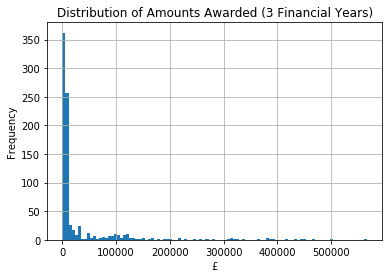

In [48]:
hist_3_FY = UK_data_merged_3FY_edited ['Amount_Awarded'].hist(bins=100)
plt.title("Distribution of Amounts Awarded (3 Financial Years)")
plt.xlabel("£")
plt.ylabel("Frequency")

In [49]:
Over_60K = UK_data_merged_3FY_edited.loc[UK_data_merged_3FY_edited['Amount_Awarded'] > 60000]

In [50]:
Over_60K.shape

(125, 45)

In [51]:
under_15K = UK_data_merged_3FY_edited.loc[UK_data_merged_3FY_edited['Amount_Awarded']  <15000]
under_15K.shape

(632, 45)

### Amounts Awarded by Financial Year (n= 844)

Replotting the box plot to look at the distributions of amounts awarded by financial year. Recall that a box plot helps show comparisons between variables or across levels of a categorical variable - in this case financial year. The main body of the box plot showing the quartiles (25th and 75th percentile). The medians have horizontal lines at the median of each box and while whiskers have the vertical lines extending to the most extreme, non-outlier data points and caps are the horizontal lines at the ends of the whiskers.
Outliers are defined as points that lie 1.5 times the interquartile range past the quartlies.

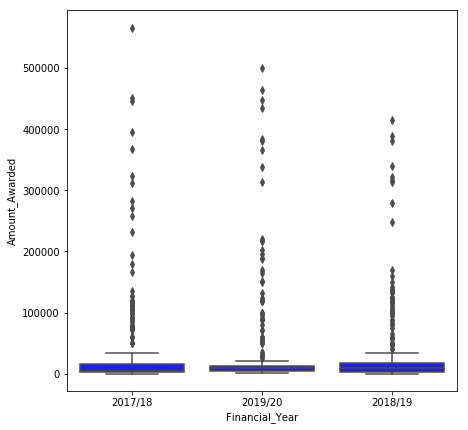

In [52]:
plt.figure(figsize=(7,7))
sn.boxplot(
    data=UK_data_merged_3FY_edited,
    x='Financial_Year',
    y='Amount_Awarded',
    color='blue')

In [53]:
#Let's look at descriptive stats for the grouped data
UK_data_merged_3FY_edited['Amount_Awarded'].groupby(UK_data_merged_3FY_edited['Financial_Year']).describe()

,count,mean,std,min,25%,50%,75%,max
Financial_Year,,,,,,,,
2017/18,310.0,31048.270742,73130.851365,100.0,2029.665,5000.0,15000.0,566160.0
2018/19,262.0,33409.534809,68269.200772,100.0,3500.000,9345.0,18000.0,415002.0
2019/20,272.0,35470.080882,81045.908836,360.0,4268.945,9079.5,12053.0,500000.0


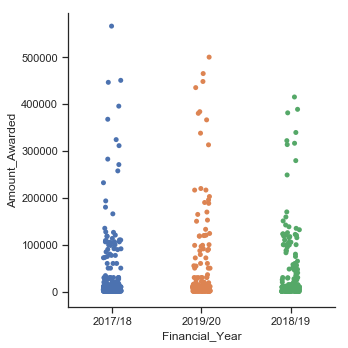

In [54]:
#Let's bring Funder in?
sn.set(style="ticks")

g = sn.catplot(x="Financial_Year", y="Amount_Awarded", data=UK_data_merged_3FY_edited)



In [55]:
UK_data_merged_3FY_edited.to_csv ('C:/Users/sonja/Desktop/Life_Admin/Bereavement_Services/UK_data_merged_3FY_edited.csv') 
                  #index = False, header=True)

In [79]:
#data['Funding_Org_Name'].value_counts().head(70).plot(
 #   kind='barh', figsize = (20,60))

In [76]:
#data['Funding_Org_Name'].value_counts()

In [77]:
#data['Recipient_Org_Name'].value_counts().head(400).plot(
   # kind='barh', figsize=(30,300))

### Which Funders gave the largest grants (on average?)

In [80]:
#group_by_funder = data.groupby('Funding_Org_Name')
#We're grouping the data by funder
#and then the mean amount awarded 
#print (group_by_funder['Amount_Awarded'].agg(np.mean))#.sort_values(by = 'ascending')
#print (group_by_funder['Amount_Awarded'].agg([np.sum, np.size, np.mean, np.std]))

In [18]:
#Where next:
#1) Find out which funders started contributing to 360G when? 

####Working with entire dataset ( n = 1139)
# 2)# Add a new column for the financial year; set condition based on Award
#Date column to arrive at financial year entry  - DONE
#3) Look at how a) Numbers of Awards and b) Amounts awarded change by FY - DONE

#### Working with the subset of data for which we have planned duration (n = 943)
#4) Look at distribution of planned duration
### - a) do this for the whole dataset
    ### - hist, box & whiskers & swarm plot?
### - b) do this for the different financial years
##### - need something that captures and shows dbn.

### Work with the subset of the data for which we have recipient district (n=693)
 #- will have a look. not sure what we would be able to conclude.
    

In [81]:
#IGNORE
#df[df['var1'].str[0] == 'A']
#https://www.listendata.com/2019/07/how-to-filter-pandas-dataframe.html
#England = data[data['Recipient_District_Geographic_Code'].str[0]=="E"]
#England.shape
#nulls are homeless currently